In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import shap
import joblib

In [3]:
print('\n=== TASK 1: Telco Churn Pipeline ===\n')


# 1) Load dataset (public raw URL) - change path if needed
DATA_URL = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
try:
  df = pd.read_csv(DATA_URL)
except Exception:
  print('Could not fetch from URL. Ensure you have connectivity or place Telco-Customer-Churn.csv locally.')
  df = pd.read_csv('Telco-Customer-Churn.csv')

print('Rows,Cols:', df.shape)


=== TASK 1: Telco Churn Pipeline ===

Rows,Cols: (7043, 21)


# **EDA**

In [4]:
# Quick EDA
print(df.head())
print('\nnulls per column:\n', df.isnull().sum())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

# **VISUALIZATION**

/tmp/ipython-input-565801247.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Churn", data=df, palette="coolwarm")


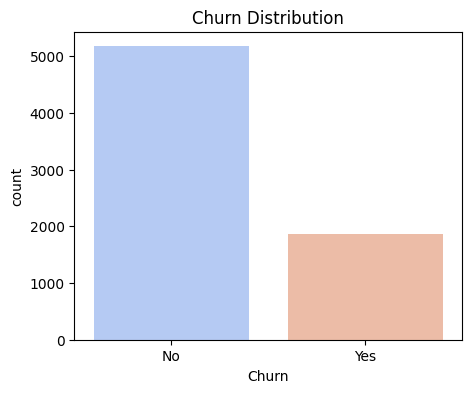

In [5]:
# Target Distribution
plt.figure(figsize=(5,4))
sns.countplot(x="Churn", data=df, palette="coolwarm")
plt.title("Churn Distribution")
plt.show()

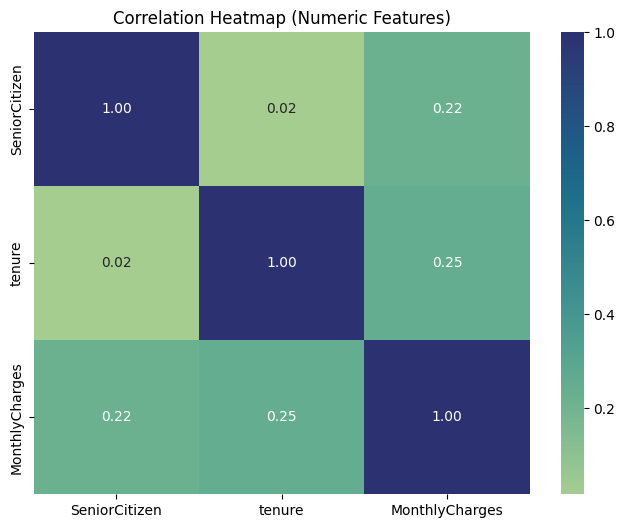

In [6]:
# Correlation heatmap for numeric features
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="crest", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


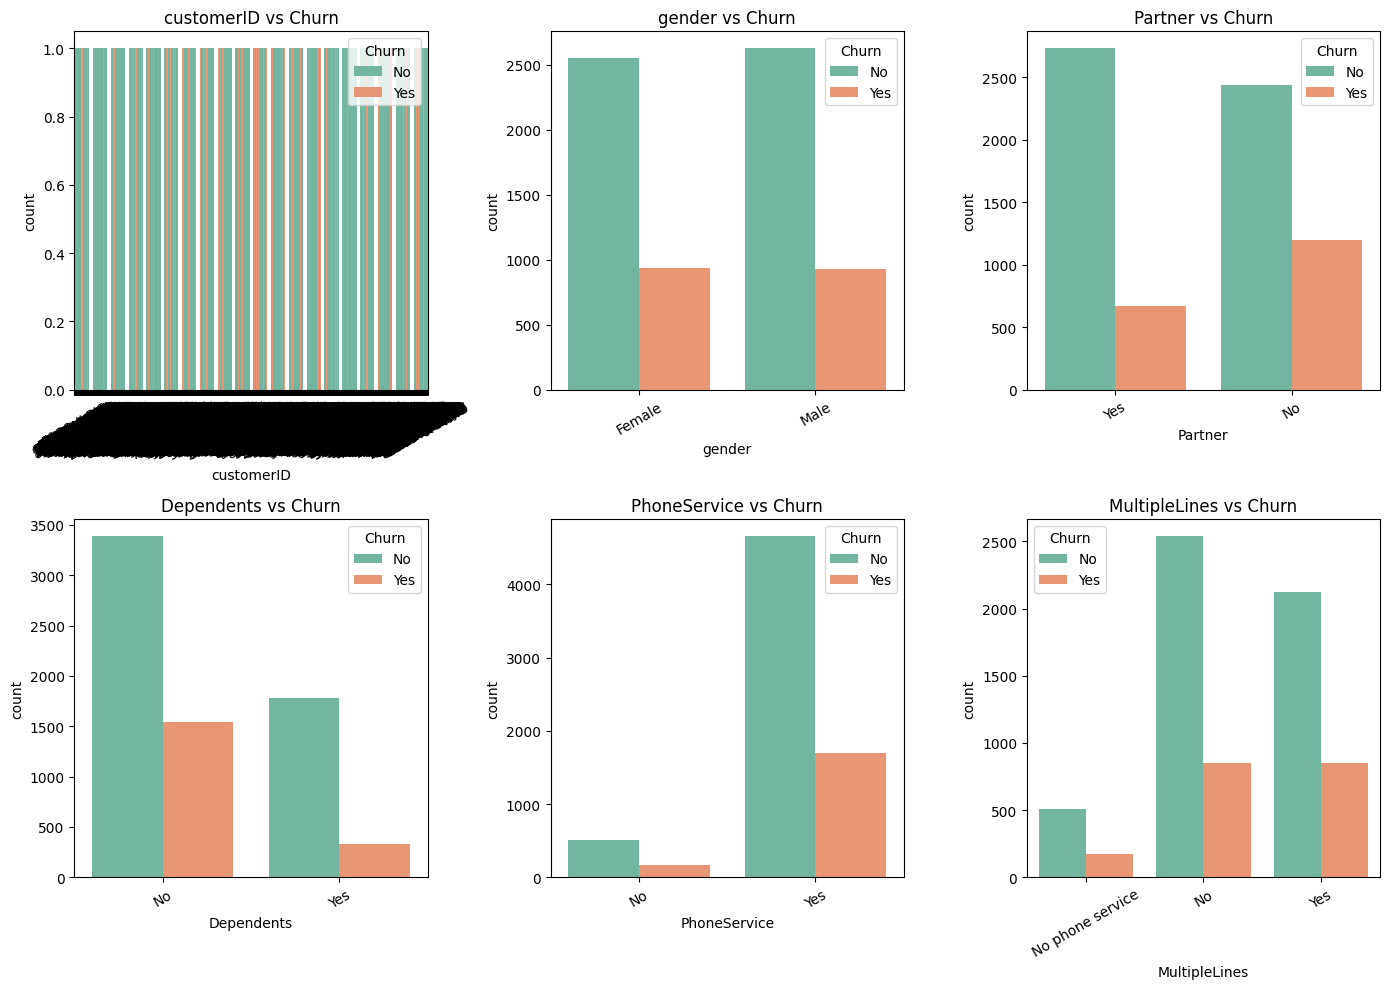

In [7]:
# Churn vs categorical features
cat_cols = [c for c in df.columns if df[c].dtype == "object" and c != "Churn"]

plt.figure(figsize=(14, 10))
for i, col in enumerate(cat_cols[:6]):  # first 6 categorical cols
    plt.subplot(2, 3, i+1)
    sns.countplot(data=df, x=col, hue="Churn", palette="Set2")
    plt.xticks(rotation=30)
    plt.title(f"{col} vs Churn")

plt.tight_layout()
plt.show()

/tmp/ipython-input-2225651653.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Churn", y=col, palette="viridis")
/tmp/ipython-input-2225651653.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Churn", y=col, palette="viridis")
/tmp/ipython-input-2225651653.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Churn", y=col, palette="viridis")


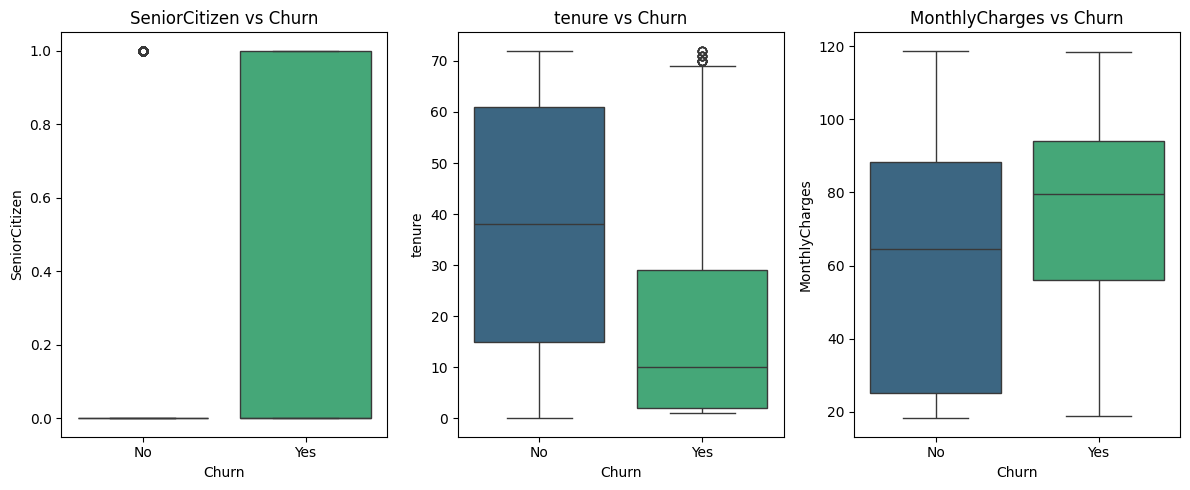

In [8]:
# Boxplot for numeric features vs Churn
num_cols = df.select_dtypes(include=["float64", "int64"]).columns
plt.figure(figsize=(12, 5))
for i, col in enumerate(num_cols):
    plt.subplot(1, len(num_cols), i+1)
    sns.boxplot(data=df, x="Churn", y=col, palette="viridis")
    plt.title(f"{col} vs Churn")

plt.tight_layout()
plt.show()

# **PREPROCESSING**

In [11]:
# Clean & preprocess simple fixes
# Drop customerID
if 'customerID' in df.columns:
  df = df.drop('customerID', axis=1)


# Convert TotalCharges to numeric (coerce errors)
if 'TotalCharges' in df.columns:
  df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')


# Fill numeric nulls
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if 'Churn' in cat_cols:
  cat_cols.remove('Churn')


# Inspect target
print('\nTarget distribution:')
print(df['Churn'].value_counts(normalize=True))


Target distribution:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [12]:
# Train-test split
X = df.drop('Churn', axis=1)
y = df['Churn'].map({'Yes':1, 'No':0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# Define preprocessing
numeric_features = [c for c in X_train.columns if X_train[c].dtype in ['float64', 'int64']]
categorical_features = [c for c in X_train.columns if c not in numeric_features]


numeric_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())
])


categorical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='most_frequent')),
('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(transformers=[
('num', numeric_transformer, numeric_features),
('cat', categorical_transformer, categorical_features)
])

# **ML PIPELINE**

In [14]:
# Full pipeline with classifier placeholder
pipeline = Pipeline(steps=[
('preprocessor', preprocessor),
('clf', RandomForestClassifier(random_state=42))
])


# Hyperparameter grid for RandomForest and LogisticRegression
param_grid = [
{
'clf': [RandomForestClassifier(random_state=42)],
'clf__n_estimators': [100, 200],
'clf__max_depth': [None, 10]
},
{
'clf': [LogisticRegression(max_iter=1000)],
'clf__C': [0.1, 1.0, 10]
}
]

In [15]:
# GridSearchCV
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
print('Starting GridSearchCV...')
grid.fit(X_train, y_train)
print('Best params:', grid.best_params_)

Starting GridSearchCV...
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Best params: {'clf': LogisticRegression(max_iter=1000), 'clf__C': 10}


In [16]:
# Evaluate
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print('\nAccuracy:', accuracy_score(y_test, y_pred))
print('F1-score:', f1_score(y_test, y_pred))
print('\nClassification report:\n', classification_report(y_test, y_pred))


Accuracy: 0.8055358410220014
F1-score: 0.6040462427745664

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



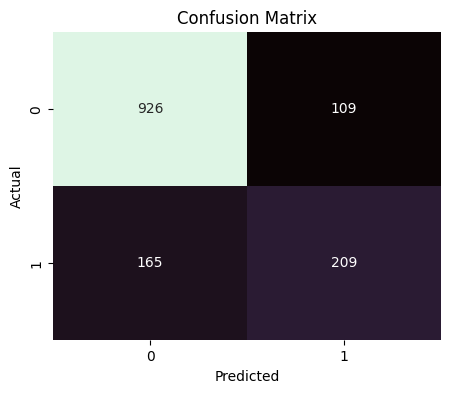

In [17]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="mako", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


___ Model Explainability with SHAP ___


/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


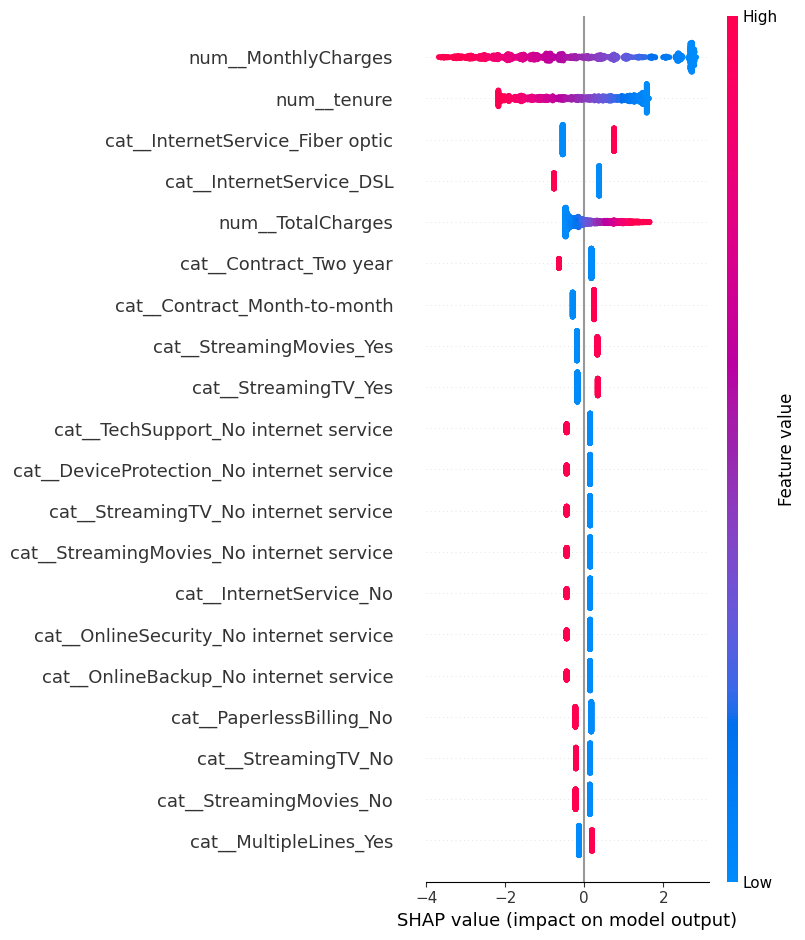

In [19]:
import shap

print("\n___ Model Explainability with SHAP ___")

# Get preprocessed test data
X_test_transformed = best_model.named_steps["preprocessor"].transform(X_test)

# Pick the classifier
clf = best_model.named_steps["clf"]

# For tree models (RandomForest, XGBoost, etc.)
if hasattr(clf, "predict_proba") and "Forest" in clf.__class__.__name__:
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_test_transformed)

# For linear models (LogisticRegression)
else:
    explainer = shap.LinearExplainer(clf, X_test_transformed, feature_perturbation="interventional")
    shap_values = explainer.shap_values(X_test_transformed)

# Plot summary
shap.summary_plot(shap_values, X_test_transformed, feature_names=best_model.named_steps["preprocessor"].get_feature_names_out())


In [20]:
# Save pipeline
joblib.dump(best_model, "telco_churn_pipeline.joblib")
print("Pipeline saved to telco_churn_pipeline.joblib")

Pipeline saved to telco_churn_pipeline.joblib
